https://gymnasium.farama.org/environments/classic_control/pendulum/

In [56]:
import gymnasium as gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [9]:
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)


In [3]:
# actor -> input : state , output : action
class MuNet(nn.Module):
    def __init__(self):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # torch.tanh() -> [-1, 1]
        # Multipled by 2 because the action space of the Pendulum-v1 is [-2,2]
        # mu = torch.tanh(self.fc_mu(x))*2
        # btw, tanh has an issue about gradient vanishing when the prior network is simple mlp
        mu = torch.clamp(self.fc_mu(x), -2., 2.)
        return mu

In [4]:
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64) #state subnetwork
        self.fc_a = nn.Linear(1,64) #action subnetwork
        self.fc_q = nn.Linear(128, 32)  
        self.fc_out = nn.Linear(32,1)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x)) #state
        h2 = F.relu(self.fc_a(a)) #action
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_q(cat))
        q = self.fc_out(q) #state action value
        return q


In [27]:
class QNet_combined(nn.Module):
    def __init__(self):
        super(QNet_combined, self).__init__()
        
        # Q1
        self.fc1_s = nn.Linear(3, 64) #state subnetwork
        self.fc1_a = nn.Linear(1,64) #action subnetwork
        self.fc1_q = nn.Linear(128, 32)  
        self.fc1_out = nn.Linear(32,1)

        # Q2
        self.fc2_s = nn.Linear(3, 64) #state subnetwork
        self.fc2_a = nn.Linear(1,64) #action subnetwork
        self.fc2_q = nn.Linear(128, 32)  
        self.fc2_out = nn.Linear(32,1)


    def forward(self, x, a):

        # Q1
        h1_x = F.relu(self.fc1_s(x)) #state
        h1_a = F.relu(self.fc1_a(a)) #action
        cat1 = torch.cat([h1_x,h1_a], dim=1)
        q1 = F.relu(self.fc1_q(cat1))
        q1 = self.fc1_out(q1) #state action value

        # Q2
        h2_x = F.relu(self.fc2_s(x)) #state
        h2_a = F.relu(self.fc2_a(a)) #action
        cat2 = torch.cat([h2_x,h2_a], dim=1)
        q2 = F.relu(self.fc2_q(cat2))
        q2 = self.fc2_out(q2) #state action value


        return q1, q2
    
    def q1net(self, x, a):
        h1_x = F.relu(self.fc1_s(x)) #state
        h1_a = F.relu(self.fc1_a(a)) #action
        cat1 = torch.cat([h1_x,h1_a], dim=1)
        q1 = F.relu(self.fc1_q(cat1))
        q1 = self.fc1_out(q1) #state action value

        return q1



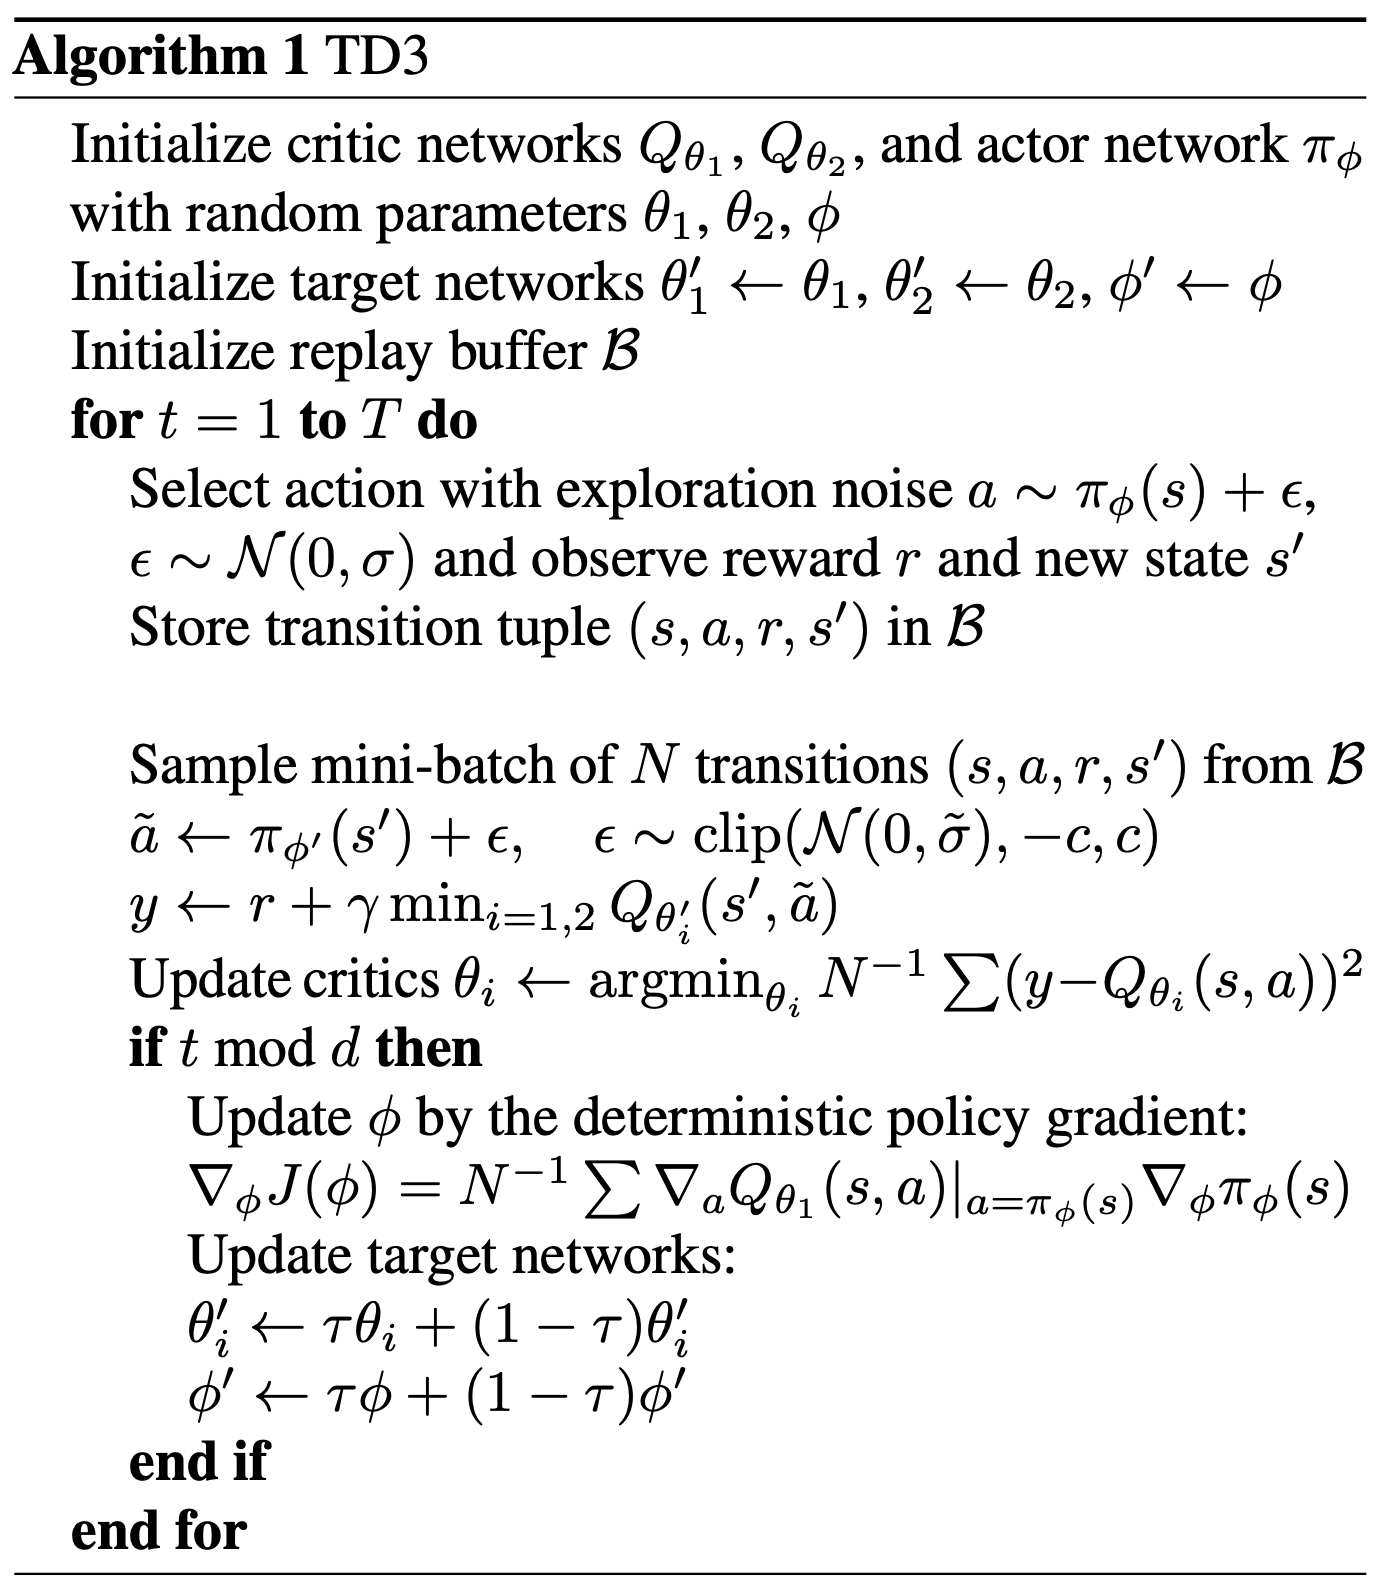

In [63]:
class TD3:
    def __init__(self,
                 lr_mu = 0.0005,
                 lr_q = 0.001,
                 gamma = 0.99,
                 batch_size = 256,
                 buffer_limit = 50000,
                 tau = 0.01,
                 policy_noise = 0.2,
                 noise_clip = 0.5,
                 policy_delay = 2,):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.buffer_limit = buffer_limit
        self.gamma = gamma
        self.lr_mu = lr_mu
        self.lr_q = lr_q
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay


        self.env = gym.make('Pendulum-v1', max_episode_steps=200, autoreset=True)
        self.memory = ReplayBuffer(self.buffer_limit)


        self.q1_nn, self.q2_nn = QNet(), QNet()
        self.q1_target_nn, self.q2_target_nn = QNet(), QNet()
        self.q1_target_nn.load_state_dict(self.q1_nn.state_dict())
        self.q2_target_nn.load_state_dict(self.q2_nn.state_dict())

        self.mu_nn, self.mu_target_nn = MuNet(), MuNet()
        self.mu_target_nn.load_state_dict(self.mu_nn.state_dict())

        self.score = 0.0
        self.print_interval = 20
        self.cnt = 0
        
        self.mu_optimizer = optim.Adam(self.mu_nn.parameters(), lr=lr_mu)
        self.q1_optimizer  = optim.Adam(self.q1_nn.parameters(), lr=lr_q)
        self.q2_optimizer  = optim.Adam(self.q2_nn.parameters(), lr=lr_q)


    def train(self):
        self.cnt += 1

        s,a,r,s_prime,done_mask = self.memory.sample(self.batch_size)
        noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
        next_action = (self.mu_target_nn(s_prime) + noise).clamp(-2,2)

        # Compute the target Q value
        target_q1, target_q2 = self.q1_target_nn(s_prime, next_action), self.q2_target_nn(s_prime, next_action) 
        target_q = torch.min(target_q1, target_q2)
        target_q = r + self.gamma * target_q * done_mask
        
        q1 = self.q1_nn(s,a)
        q2 = self.q2_nn(s,a)

        # q1, q2 loss seperately - 이거 더해서 한번에 로스 주는거랑 어떻게 다르지,,?
        q1_loss = F.smooth_l1_loss(q1, target_q.detach())
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        q2_loss = F.smooth_l1_loss(q2, target_q.detach())
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        # delayed policy update
        if self.cnt % self.policy_delay == 0:
            mu_loss = -self.q1_nn(s,self.mu_nn(s)).mean()
            self.mu_optimizer.zero_grad()
            mu_loss.backward()
            self.mu_optimizer.step()



    def soft_update(self, net, net_target):
        target_sd = net_target.state_dict()
        sd = net.state_dict()
        for key in target_sd:
            target_sd[key] = sd[key]*self.tau + target_sd[key]*(1 - self.tau)
        net_target.load_state_dict(target_sd)

    
    def train_loop(self, num_episode):
        scores = []
        for n_epi in range(num_episode):
            s, _ = self.env.reset()
            done = False

            count = 0
            # episode 길이가 200이 되거나 done이 True가 되면 종료
            while count < 200 and not done:
                a = self.mu_nn(torch.from_numpy(s).float()) #deterministic policy
                a = a.item()
                s_prime, r, done, truncated, info = self.env.step([a])
                self.memory.put((s,a,r/100.0,s_prime,done))
                self.score +=r
                s = s_prime
                count += 1
            
            if self.memory.size()>2000:
                self.soft_update(self.mu_nn, self.mu_target_nn)
                self.soft_update(self.q1_nn,  self.q1_target_nn)
                self.soft_update(self.q2_nn,  self.q2_target_nn)
            
            if n_epi%self.print_interval==0 and n_epi!=0:
                print("# of episode :{}, avg score : {:.1f}".format(n_epi, self.score/self.print_interval))
                scores.append(self.score/self.print_interval)
                self.score = 0.0

        self.env.close()
        return scores

In [64]:
scores = TD3().train_loop(7000)

# of episode :20, avg score : -1408.7
# of episode :40, avg score : -1382.7
# of episode :60, avg score : -1327.4
# of episode :80, avg score : -1310.6
# of episode :100, avg score : -1330.3
# of episode :120, avg score : -1386.5
# of episode :140, avg score : -1309.2
# of episode :160, avg score : -1327.6
# of episode :180, avg score : -1357.9
# of episode :200, avg score : -1276.3
# of episode :220, avg score : -1391.2
# of episode :240, avg score : -1321.9
# of episode :260, avg score : -1329.1
# of episode :280, avg score : -1358.7
# of episode :300, avg score : -1220.4
# of episode :320, avg score : -1286.7
# of episode :340, avg score : -1425.8
# of episode :360, avg score : -1342.5
# of episode :380, avg score : -1303.6
# of episode :400, avg score : -1290.4
# of episode :420, avg score : -1510.4
# of episode :440, avg score : -1277.9
# of episode :460, avg score : -1345.4
# of episode :480, avg score : -1360.6
# of episode :500, avg score : -1358.7
# of episode :520, avg score 

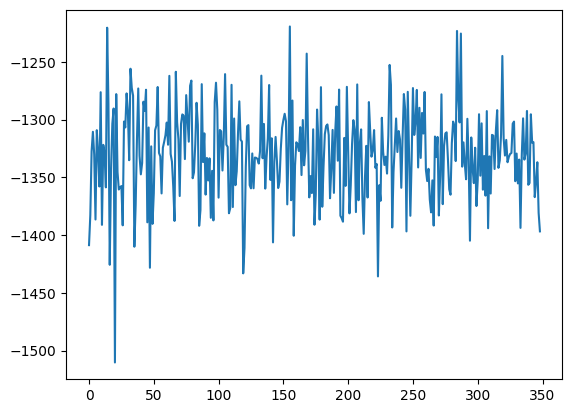

In [65]:
plt.plot(scores)

In [50]:
class TD3_combined:
    def __init__(self,
                 lr_mu = 0.0005,
                 lr_q = 0.001,
                 gamma = 0.99,
                 batch_size = 256,
                 buffer_limit = 50000,
                 tau = 0.01,
                 policy_noise = 0.2,
                 noise_clip = 0.5,
                 policy_delay = 2,):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.buffer_limit = buffer_limit
        self.gamma = gamma
        self.lr_mu = lr_mu
        self.lr_q = lr_q
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay


        self.env = gym.make('Pendulum-v1', max_episode_steps=200, autoreset=True)
        self.memory = ReplayBuffer(self.buffer_limit)


        self.q_nn, self.q_target_nn = QNet_combined(), QNet_combined()
        self.q_target_nn.load_state_dict(self.q_nn.state_dict())

        self.mu_nn, self.mu_target_nn = MuNet(), MuNet()
        self.mu_target_nn.load_state_dict(self.mu_nn.state_dict())

        self.score = 0.0
        self.print_interval = 20
        self.cnt = 0
        
        self.mu_optimizer = optim.Adam(self.mu_nn.parameters(), lr=lr_mu)
        self.q_optimizer  = optim.Adam(self.q_nn.parameters(), lr=lr_q)


    def soft_update(self, net, net_target):
        target_sd = net_target.state_dict()
        sd = net.state_dict()
        for key in target_sd:
            target_sd[key] = sd[key]*self.tau + target_sd[key]*(1 - self.tau)
        net_target.load_state_dict(target_sd)


    def train(self):
        self.cnt += 1

        s,a,r,s_prime,done_mask = self.memory.sample(self.batch_size)
        noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
        next_action = (self.mu_target_nn(s_prime) + noise).clamp(-2,2)

        # Compute the target Q value
        target_q1, target_q2 = self.q_target_nn(s_prime, next_action)
        target_q = torch.min(target_q1, target_q2)
        target_q = r + self.gamma * target_q * done_mask
        
        q1, q2 = self.q_nn(s,a)

        # q1, q2 loss seperately - 
        q_loss = F.smooth_l1_loss(q1, target_q.detach()) + F.smooth_l1_loss(q2, target_q.detach())
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        
        # delayed policy update
        if self.cnt % self.policy_delay == 0:
            mu_loss = -self.q_nn.q1net(s,self.mu_nn(s)).mean()
            self.mu_optimizer.zero_grad()
            mu_loss.backward()
            self.mu_optimizer.step()


    
    def train_loop(self, num_episode):
        scores = []
        for n_epi in range(num_episode):
            s, _ = self.env.reset()
            done = False

            count = 0
            # episode 길이가 200이 되거나 done이 True가 되면 종료
            while count < 200 and not done:
                a = self.mu_nn(torch.from_numpy(s).float()) #deterministic policy
                a = a.item()
                s_prime, r, done, truncated, info = self.env.step([a])
                self.memory.put((s,a,r/100.0,s_prime,done))
                self.score +=r
                s = s_prime
                count += 1
                    
            if self.memory.size()>2000:
                self.train()
                self.soft_update(self.mu_nn, self.mu_target_nn)
                self.soft_update(self.q_nn,  self.q_target_nn)
            
            if n_epi%self.print_interval==0 and n_epi!=0:
                print("# of episode :{}, avg score : {:.1f}".format(n_epi, self.score/self.print_interval))
                scores.append(self.score/self.print_interval)
                self.score = 0.0

        self.env.close()
        return scores

In [51]:
scores = TD3_combined().train_loop(7000)

# of episode :20, avg score : -1411.5
# of episode :40, avg score : -1391.6
# of episode :60, avg score : -1450.7
# of episode :80, avg score : -1405.6
# of episode :100, avg score : -1377.4
# of episode :120, avg score : -1329.9
# of episode :140, avg score : -1317.6
# of episode :160, avg score : -1274.0
# of episode :180, avg score : -1418.4
# of episode :200, avg score : -1363.5
# of episode :220, avg score : -1270.1
# of episode :240, avg score : -1235.5
# of episode :260, avg score : -1323.9
# of episode :280, avg score : -1342.5
# of episode :300, avg score : -1226.9
# of episode :320, avg score : -1242.3
# of episode :340, avg score : -1297.8
# of episode :360, avg score : -1302.4
# of episode :380, avg score : -1243.2
# of episode :400, avg score : -1247.2
# of episode :420, avg score : -1292.6
# of episode :440, avg score : -1142.2
# of episode :460, avg score : -1252.9
# of episode :480, avg score : -1215.5
# of episode :500, avg score : -1140.3
# of episode :520, avg score 

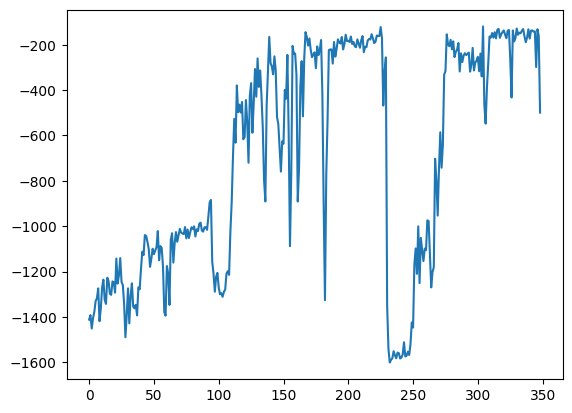

In [55]:
plt.plot(scores)

In [ ]:
scores = TD3_combined().train_loop(7000)